# 9.ChIP-seq
## 9.6 Peak calling
### 9.6.4 Peak quality control
input サンプルの seq depth が十分でない場合、誤って enriched regions を同定してしまう可能性がある。
TF ChIP-seq の場合、TF モチーフ配列が存在するかどうかも、データの品質に問題ないかどうかを判断する重要な指標となる。

#### 9.6.4.1 ピークのリード数の割合

In [1]:
# ChIP-seq のデータのルートパス
data_path = "../data/chip-seq"

# H3K36me3 の ChIP-seq データのファイルパスを取得
chip_file    = file.path(data_path, 'GM12878_hg38_H3K36me3.chr21.bam')

# input データのファイルパスを取得
control_file = file.path(data_path, 'GM12878_hg38_Input_r5.chr21.bam')

In [3]:
library(normr)

In [4]:
# window width を 5000bp に設定
countConfiguration = countConfigSingleEnd(binsize = 5000)

# enrichR を使って broad peaks を同定する
h3k36_fit = enrichR(
            
            # ChIP ファイル
            treatment   = chip_file,
            
            # control ファイル
            control     = control_file,
            
            # ゲノムバージョン
            genome      = "hg38",
            verbose     = FALSE,
            
            # window サイズ
            countConfig = countConfiguration)

Warning message:
“'fetchExtendedChromInfoFromUCSC' is deprecated.
Use 'getChromInfoFromUCSC' instead.
See help("Deprecated")”
Warning message in .local(bampath, gr, ...):
“some ranges' widths are not a multiple of the selected
             binsize, some bins will correspond to less than binsize basepairs”
Warning message in .local(bampath, gr, ...):
“some ranges' widths are not a multiple of the selected
             binsize, some bins will correspond to less than binsize basepairs”


In [5]:
# tilling window ごとのリード数を取得(data.frame に変換)
h3k36_counts = data.frame(getCounts(h3k36_fit))

In [9]:
# カラム名を変更
colnames(h3k36_counts) = c('Input','H3K36me3')

In [10]:
# q-value を取得
h3k36_counts$qvalue = getQvalues(h3k36_fit)

In [11]:
# dq value cutoff を使って、各 window 領域がピークかどうか定義
h3k36_counts$enriched[is.na(h3k36_counts$qvalue)]  = 'Not Peak'
h3k36_counts$enriched[h3k36_counts$qvalue > 0.05]  = 'Not Peak'
h3k36_counts$enriched[h3k36_counts$qvalue <= 0.05] = 'Peak'

In [24]:
# q value カラムを削除
h3k36_counts$qvalue = NULL
h3k36_counts[1500:1504,]

,Input,H3K36me3,enriched
,<int>,<int>,<chr>
1500,0,0,Not Peak
1501,0,0,Not Peak
1502,0,0,Not Peak
1503,0,0,Not Peak
1504,0,0,Not Peak


In [13]:
library("tidyr")

In [19]:
# data.frame を整形
h3k36_counts_df = tidyr::pivot_longer(
    data      = h3k36_counts, 
    cols      = -enriched,
    names_to  = 'experiment',
    values_to = 'counts'
)

In [21]:
h3k36_counts_df[300:304,]

enriched,experiment,counts
<chr>,<chr>,<int>
Not Peak,H3K36me3,0
Not Peak,Input,0
Not Peak,H3K36me3,0
Not Peak,Input,0
Not Peak,H3K36me3,0


In [27]:
library("dplyr")

In [28]:
# enriched(ピーク領域 or それ以外の領域)と experiment(H3K36me3 or Input) でグループ化
h3k36_counts_df = group_by(.data = h3k36_counts_df, experiment, enriched)

In [31]:
# ピーク領域 or それ以外の領域のリード数の合計を取得
h3k36_counts_df = summarize(.data = h3k36_counts_df, num_of_reads = sum(counts))

`summarise()` regrouping output by 'experiment' (override with `.groups` argument)



In [32]:
h3k36_counts_df

experiment,enriched,num_of_reads
<chr>,<chr>,<int>
H3K36me3,Not Peak,67623
H3K36me3,Peak,90993
Input,Not Peak,492369
Input,Peak,155827


In [33]:
# experiment(H3K36me3 or Input) でグループ化
h3k36_counts_df = group_by(.data = h3k36_counts_df, experiment)

In [34]:
# Total リード数を列として追加
h3k36_counts_df = mutate(.data = h3k36_counts_df, total=sum(num_of_reads))

In [35]:
h3k36_counts_df

experiment,enriched,num_of_reads,total
<chr>,<chr>,<int>,<int>
H3K36me3,Not Peak,67623,158616
H3K36me3,Peak,90993,158616
Input,Not Peak,492369,648196
Input,Peak,155827,648196


In [36]:
# リード数の割合を列として追加
h3k36_counts_df$percentage = with(h3k36_counts_df, round(num_of_reads/total,2))

In [37]:
h3k36_counts_df

experiment,enriched,num_of_reads,total,percentage
<chr>,<chr>,<int>,<int>,<dbl>
H3K36me3,Not Peak,67623,158616,0.43
H3K36me3,Peak,90993,158616,0.57
Input,Not Peak,492369,648196,0.76
Input,Peak,155827,648196,0.24


In [38]:
library("ggplot2")

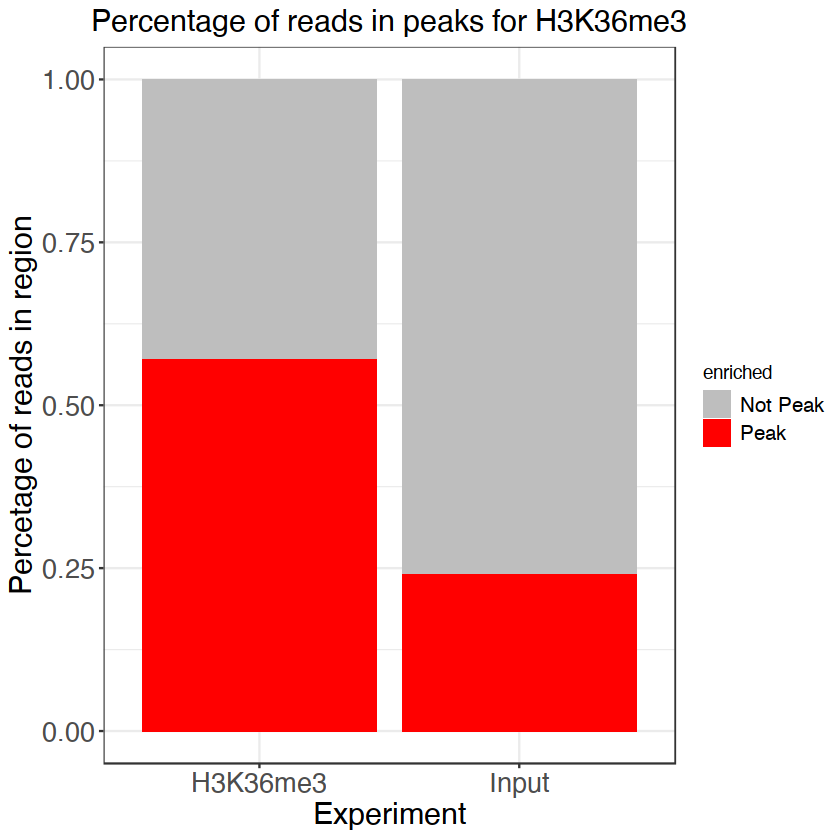

In [51]:
ggplot(
    data = h3k36_counts_df, 
    aes(
        x = experiment, 
        y = percentage, 
        fill = enriched
    )) +
    geom_bar(stat='identity', position='fill') +
    theme_bw() +
    theme(
        axis.text = element_text(size=16, face='bold'),
        axis.title = element_text(size=18,face="bold"),
        plot.title = element_text(size=18,hjust = 0.5),
        legend.text=element_text(size=12)) +
    xlab('Experiment') +
    ylab('Percetage of reads in region') +
    ggtitle('Percentage of reads in peaks for H3K36me3') +
    scale_fill_manual(values=c('gray','red'))

ピーク領域で Input のリード数よりも H3K36me3 のリード数のほうが多い。  
リード数の割合は、抗体の質にも依存している。